## Information Gain via Decision Trees
### Description:
When creating a decision tree, the algorithm that is employed recursively splits
based on different feature's values to keep the same labels grouped together. When creating the tree,
candidate splits are considered based on tuples made up of a feature and threshold (for that feature). 
The proposed split is applied and the impurity of labels as a result of that split is computed.
By choosing each split such that it minimizes the impurity of the group of labels (maximizes the homogeneity),
we create a decision tree. 

### Benefits : 
By creating the decision tree, the Gini Importance (normalized mean decrease in impurity) is computed for each feature. In other words, the effectiveness of a feature to predict a certain label is computed allowing us to see which signals are the largest contributors to outage or not outage. This should provide us with some sense of 'correlation' between a considered set of signals and outage. 

### Output : 
<b>Feature Importance</b> : A set of features and their computed importance.

In [7]:
from sklearn.datasets import load_iris
from sklearn import tree

# Load Iris data set
iris = load_iris()
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(iris.data, iris.target)
print(type(iris))

for name, importance in zip(iris['feature_names'], tree_clf.feature_importances_):
    print(name, importance)


<class 'sklearn.datasets.base.Bunch'>
('sepal length (cm)', 0.013333333333333329)
('sepal width (cm)', 0.0)
('petal length (cm)', 0.064055958132045052)
('petal width (cm)', 0.92261070853462157)


## Dynamic Time Warping
### Description
Algorithm for measuring similarity between two temporal sequences that are distorted from one another in the time axis.
### Benefits : 
Different signals in the system may show similar patterns at different lags from each other. This caveat is an artifact of how the system is designed. To circumvent this issue, dynamic time warping provides us with a solution.  
### Output : 
<b>Distance</b> : The distance of the optimal warp path.<br>
<b>Path</b> : $W = w_{1},...,w_{k}$ where $w_{k} = (i,j)$ where $i$ is an index from a time series $X$ and $j$ is an index from time series $Y$ 

In [3]:
### Time Series - Dynamic Time Warping ###
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(x, y, dist=euclidean)
print(path)
print(distance)

[(0, 0), (1, 0), (2, 1), (3, 2), (4, 2)]
2.82842712475


## Pearson Correlation
### Description:
For two time series, we can measure the pearson correlation between the two time series.
The below shows a removal of trend via differencing followed by computing the pearson correlation
between the remaining seasonalities of the original set of time series.
### Benefits : 
Measure the correlation between two time series. Most likely, this will not be enough and one needs to perform some preprocessing before. 
### Output : 
<b>Pearson Correlation Matrix</b>: Matrix containing the correaltion computed between all pairs of time series.

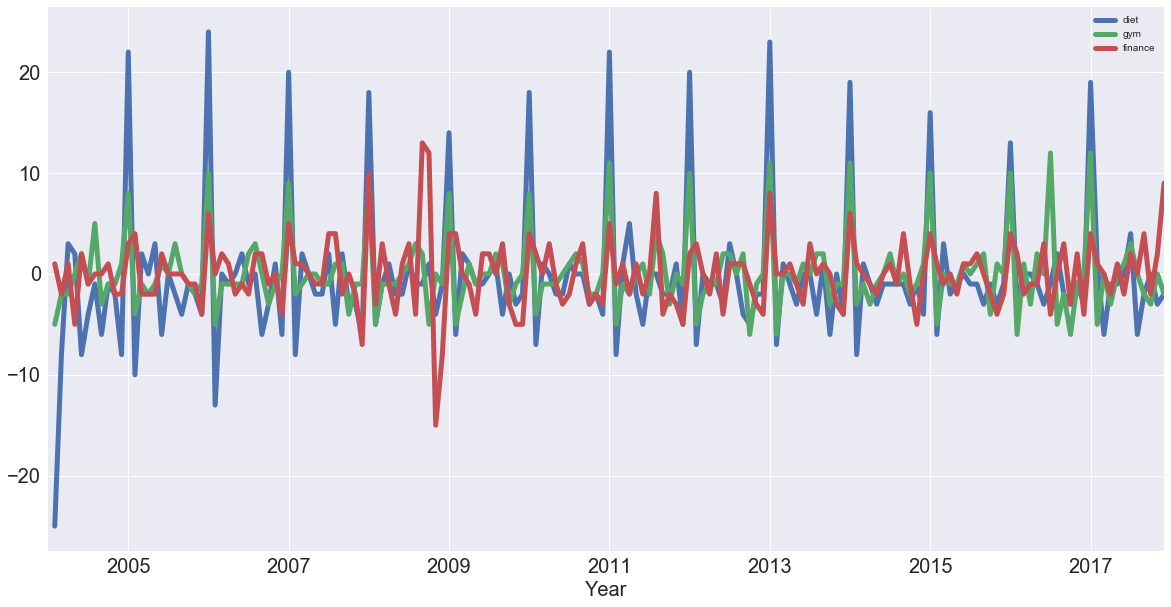

             diet       gym   finance
diet     1.000000  0.758707  0.373828
gym      0.758707  1.000000  0.301111
finance  0.373828  0.301111  1.000000


In [29]:
### Pearson Correlation ie. Seasonality ###

# Import packages# Impor 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Load google word freq. Dataset
df = pd.read_csv('data/multiTimeline.csv', skiprows=1)
df.columns = ['month', 'diet', 'gym', 'finance']
df.month = pd.to_datetime(df.month)
df.set_index('month', inplace=True)
df.head()

# Plot the TS
df.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.show()

# Print correlation between differenced (seasonal components) of timeseries
print(df.diff().corr())


## Cross-Correlation
### Description
Similar to dynamic time warping, but instead of using a euclidean distance  the normalized cross-covariance function (Pearson Correlation) is used. In other words, this allows us to determine the lag required for both time series to be considered most similar. Given the statistical nature of this method, both time series must be stationary (constant mean and varaince) for this technique to be effective. 
### Benefits : 
Different signals in the system may show similar patterns at different lags from each other. This caveat is an artifact of how the system is designed. To circumvent this issue, cross-correlation solves this issue.
### Output : 
<b>Cross-Correlation Matrix @ different lags</b> : The output of the cross-correlation function is a triangular matrix of the cross-correlation computed between two time series at different lags. 

In [1]:
### Time Series - Cross Correlation ###
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline


def df_derived_by_shift(df,lag=0,NON_TS=[]):
    '''
    Adds lag to TS columns of df
    '''
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_TS:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

def cross_correlation(df, lag=0, NON_TS=[]):
    '''
    Computes cross-correlation between time series
    '''
    df = df.copy()
    lagged_df = df_derived_by_shift(df, lag=lag, NON_TS = NON_TS)
    lagged_df= lagged_df.dropna()
    return lagged_df.corr()

# Load Data
df = pd.read_csv('./data/sudeste.csv')
dfx = df[(df['wsid']==384) & (df['mdct'] > '2015-01-01 00:00:00')  ]
fields = ['mdct','temp','hmdy'] # mdct is datetime 
x = dfx[fields]
# Compute cross correlation
# Columns that should not be lagged
NON_TS = ['mdct',]
df_corr = cross_correlation(x, 3, NON_TS)
print(df_corr)

            temp      hmdy    hmdy_1    hmdy_2    hmdy_3    temp_1    temp_2  \
temp    1.000000 -0.511730 -0.555683 -0.494938 -0.411060  0.888854  0.819054   
hmdy   -0.511730  1.000000  0.817123  0.713665  0.595967 -0.558331 -0.494671   
hmdy_1 -0.555683  0.817123  1.000000  0.817116  0.713654 -0.511695 -0.558302   
hmdy_2 -0.494938  0.713665  0.817116  1.000000  0.817106 -0.555656 -0.511668   
hmdy_3 -0.411060  0.595967  0.713654  0.817106  1.000000 -0.494912 -0.555635   
temp_1  0.888854 -0.558331 -0.511695 -0.555656 -0.494912  1.000000  0.888846   
temp_2  0.819054 -0.494671 -0.558302 -0.511668 -0.555635  0.888846  1.000000   
temp_3  0.731785 -0.403980 -0.494635 -0.558269 -0.511643  0.819041  0.888838   

          temp_3  
temp    0.731785  
hmdy   -0.403980  
hmdy_1 -0.494635  
hmdy_2 -0.558269  
hmdy_3 -0.511643  
temp_1  0.819041  
temp_2  0.888838  
temp_3  1.000000  


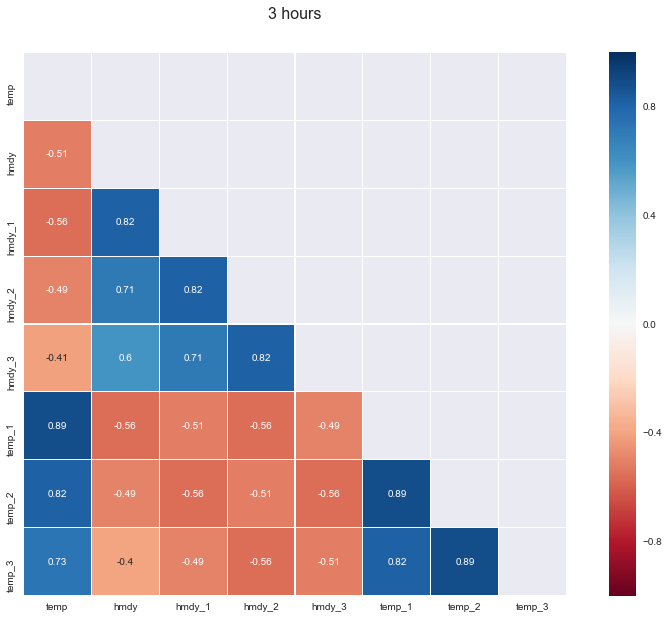

In [39]:
### Plot cross correlation ###
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'3 hours', y=1.05, size=16)

mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_corr, mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

plt.show()
